# Article Topic Analysis
## Overview
The purpose of this repository is to analyse,visualize,and list the topics included in a set of articles.<br>
These articles come from a dataset I have created over the last two years by collecting the URLs of articles of interest.
## Process
1. Data Extraction: Download text from each url (using BeautifuSoup)
2. Data Cleansing: Clean dataset with common NLP techniques (stopword removal, lemmatization, etc.) (using NLTK)
3. Saving Data: Saving the extracted dataset
4. Data Visualization: Visualize with PCA or T-SNE (using Scikit-learn)
5. 

In [29]:
# Imports

#NLP
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#website scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup

#file manipulation
import pickle
import glob
import csv

#data manipulation
import numpy as np
import pandas as pd
from collections import defaultdict

#dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#utils
import time

## Data Extraction and Cleansing

In [2]:
# text extraction
def openUrlAndExtractText(url):
    site  = urlopen(url)
    soup = BeautifulSoup(site, "html.parser")
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    text = soup.getText()
    text = text.lower()
    
    return text
    
def extractSentencesFromText(text,minSizeOfSentence):
    sentences = text.split("\n")
    
    #remove short sentences
    sentences = [elem for elem in sentences if len(elem) >= minSizeOfSentence]
    
    extractedSentences = []
    #checking for multiple sentences within each line with nltk
    for sentence in sentences:
        extractedSentences.extend(sent_tokenize(sentence))
        
    return extractedSentences

def cleanSentences(sentences):
    cleanSentences = []
    for sentence in sentences:
        if len(sentence) <= 1:
            continue
        cleanSentences.append(sentence.strip())
        
    return cleanSentences

def turnSenteceListToWordCountDict(sentences):
    wordCountDict = defaultdict(int)
    for s in sentences:
        words = word_tokenize(s)
        for word in words:
            wordCountDict[word] += 1
    return wordCountDict


In [3]:
#loading dataset
def getDatasetURLList(fileLoc):
    dataUrls = []

    with open(fileLoc) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            dataUrls.append(row[0])
    return dataUrls



## NLP Cleansing

In [4]:
#nlp cleaning methods
def nlpCleaning(wordCountDict):
    #remove stop words
    wordCountDict = removeStopWords(wordCountDict)
    
    #lemmatize words
    wordCountDict = lemmatizeWordCountDict(wordCountDict)
    
    #
    
    return wordCountDict

def removeStopWords(wordCountDict):
    cleanedWordCountDict = defaultdict(int)
    
    for word,count in wordCountDict.items():
        if word not in stopwords.words('english'):
            cleanedWordCountDict[word] = count
    
    return cleanedWordCountDict
        
def lemmatizeWordCountDict(wordCountDict):
    lemmatizedWordCountDict = defaultdict(int)
    
    lemmatizer = WordNetLemmatizer()
    
    for word,count in wordCountDict.items():
        lemmatizedWordCountDict[lemmatizer.lemmatize(word, get_wordnet_pos(word))] += count
    
    return lemmatizedWordCountDict

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Running Data extraction

In [ ]:
#Input variables
dataSetCSVLocation = 'Data/Article_urls_KeepTransfer0_5.csv'
dataUrls = getDatasetURLList(dataSetCSVLocation)

minSizeOfSentence = 2

articlesPerSaveFile = 25

#other variables
wordCountDicts = []

successes = 0
errors = 0

start = time.time()

print("Starting")
#extracting the data from each url
for url in dataUrls[177:]:
    if successes + errors == 177:
        continue
    try:
        #extracting raw text from site
        rawText =  openUrlAndExtractText(url)
        #finding sentences in the text
        rawSentences = extractSentencesFromText(rawText,minSizeOfSentence)
        #cleaning sentences up
        cleanedSentences = cleanSentences(rawSentences)

        wordCountDict = turnSenteceListToWordCountDict(cleanedSentences)

        cleanedWordCountDict = nlpCleaning(wordCountDict)

        wordCountDicts.append(cleanedWordCountDict)
        successes += 1
        
        if successes % articlesPerSaveFile == 0:
            with open('Data/Datafiles/_'+str(successes)+'.pickle', 'wb') as handle:
                pickle.dump(wordCountDicts, handle, protocol=pickle.HIGHEST_PROTOCOL)
                wordCountDicts = []
            print("Articles attempted:",successes+errors,"\n",successes, "saved\t", "Time Since Start:",time.time()-start)
    except:
        errors += 1
        #print(url)
    if (successes+errors) % 10 == 0:
            print(successes+errors)
    
print("Done")

Starting
10
20
30


# Visualization

In [75]:
df = pd.DataFrame()

for file in glob.glob('Data/Datafiles/*'):
    data = pickle.load(open(file, 'rb'))
    dfTemp = pd.DataFrame.from_dict(data)
    df = df.append(dfTemp)
df = df.fillna(0)
df.shape

(225, 25697)

Explained variation per principal component: [0.85600371 0.08201403]


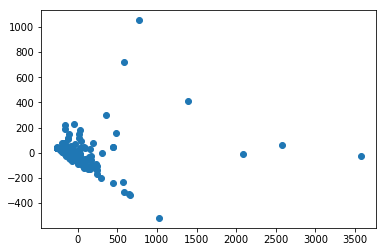

In [69]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.scatter(df["pca-one"], df["pca-two"])

In [67]:
comps = pd.DataFrame(pca.components_,columns=df.columns,index = ['pca-one','pca-two'])
comps = comps.transpose()
comps = comps.sort_values('pca-two', ascending=False)
#comps

In [93]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(df.values)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 225 samples in 0.000s...
[t-SNE] Computed neighbors for 225 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 225 / 225
[t-SNE] Mean sigma: 12.752198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.771961
[t-SNE] Error after 300 iterations: 0.625604
t-SNE done! Time elapsed: 1.6643061637878418 seconds


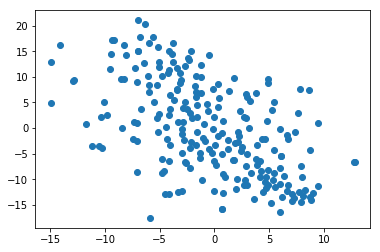

In [94]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.scatter(df["tsne-2d-one"], df["tsne-2d-two"])